In [1]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family' : "sans-serif"})
params = {'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']}
plt.rcParams.update(params)

from scipy.stats import bernoulli
from scipy.special import loggamma

from sklearn.preprocessing import OneHotEncoder

import tqdm

from rpy2.robjects import numpy2ri
from rpy2.robjects.packages import importr

In [2]:
import os
import pickle

In [3]:
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000

In [4]:
from functools import lru_cache

@lru_cache(maxsize = 10000)
def normterm_discrete(n, k):
    if n == 1:
        return np.log(k)
    if k == 1:
        return 1.0
    elif k == 2:
        return np.sum(sorted([ np.exp(loggamma(n+1) - loggamma(t+1) - loggamma(n-t+1) + 
                               t*(np.log(t) - np.log(n)) + (n-t)*(np.log(n-t) - np.log(n))
                        )
                        for t in range(1, n)]))
    else:
        return normterm_discrete(n, k-1) + n/(k-2) * normterm_discrete(n, k-2)

In [5]:
def calc_dnml(X, Z1, Z2, K=3, L=3):    
    N = X.shape[0]
    
    codelen_x_z = 0.0
    codelen_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen_x_z += n_all * np.log(n_all)
                codelen_x_z += np.log(normterm_discrete(n_all, 2))
            
            if n_pos >=2:
                codelen_x_z -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen_x_z -= n_neg * np.log(n_neg)
            
        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen_z += n_k * (np.log(N) - np.log(n_k))

    codelen_z += np.log(normterm_discrete(N, K))
    
    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [6]:
def calc_dnml_with_estimator(X, Z1, Z2, pi, theta, K=3, L=3):
    N = X.shape[0]
    
    codelen_x_z = 0.0
    codelen_z = 0.0

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen_x_z += -n_pos * np.log(theta[k, l])
                codelen_x_z += -n_neg * np.log(1 - theta[k, l])
                codelen_x_z += np.log(normterm_discrete(n_all, 2))

        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen_z += -n_k * np.log(pi[k])

    codelen_z += np.log(normterm_discrete(N, K))
    
    codelen = codelen_x_z + codelen_z

    return codelen, codelen_x_z, codelen_z

In [7]:
def calc_lsc(X, Z1, Z2, K=3, L=3):    
    codelen = 0.0
    N = X.shape[0]

    for k in range(K):
        for l in range(L):
            n_pos = np.sum(X[Z1 == k, :][:, Z2 == l] == 1)
            n_neg = np.sum(X[Z1 == k, :][:, Z2 == l] == 0)
            n_all = n_pos + n_neg

            if n_all >=2:
                codelen += n_all * np.log(n_all)
            
            if n_pos >=2:
                codelen -= n_pos * np.log(n_pos)
            if n_neg >=2:
                codelen -= n_neg * np.log(n_neg)

        n_k = np.sum(Z1 == k)
        if n_k >= 1:
            codelen += n_k * (np.log(N) - np.log(n_k))

        codelen += (k + (k+1)*(k+2))/2 * np.log(N/(2.0*np.pi)) -(k+1)/2 * np.log(2.0) + \
           (k+1) * loggamma((k+3)/2) - loggamma((k+1)*(k+3)/2) + (k+1)*(k+2)/2 * np.log(np.pi)

    return codelen

In [8]:
def calc_stats(scores, scores_f, scores_l):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    idxes_all = np.argmin(scores, axis=2)
    
    idxes_former = np.zeros((n_trial, T-2*h), dtype=np.int)
    idxes_latter = np.zeros((n_trial, T-2*h), dtype=np.int)

    for trial in range(scores.shape[0]):
        for t in range(T-2*h):
            stats_half_t = np.zeros((cluster_range_max, cluster_range_max), dtype=np.float)
            for k1 in range(cluster_range_max):
                stats_former = scores_f[trial, t, k1]
                for k2 in range(cluster_range_max):
                    stats_latter = scores_l[trial, t, k2]
                    stats_half_t[k1, k2] = stats_former + stats_latter    
            idx_f, idx_l = np.unravel_index(np.argmin(stats_half_t), (cluster_range_max, cluster_range_max))
            idxes_latter[trial, t] = idx_l
            
    stats_complete = np.zeros((idxes_all.shape[0], idxes_all.shape[1]), dtype=np.float)
    for trial in range(idxes_all.shape[0]):
        for t in range(idxes_all.shape[1]):
            stat = scores[trial, t, idxes_all[trial, t]] - 0.5*(scores_f[trial, t, idxes_former[trial, t]] + scores_l[trial, t, idxes_latter[trial, t]])
            stats_complete[trial, t] = stat
            
    stats_complete = np.hstack(([[np.nan]*2*h]*stats_complete.shape[0], stats_complete))
            
    return stats_complete, idxes_all, idxes_former, idxes_latter

In [9]:
def calc_stats_with_modelidx(scores, scores_f, scores_l, idxes_model, idxes_model_f, idxes_model_l):
    scores = np.array(scores)
    scores_f = np.array(scores_f)
    scores_l = np.array(scores_l)
    
    stats_complete = np.zeros((idxes_all.shape[0], idxes_all.shape[1]), dtype=np.float)
    for trial in range(idxes_all.shape[0]):
        for t in range(idxes_all.shape[1]):
            stat = scores[trial, t, idxes_model[trial, t]] - 0.5*(scores_f[trial, t, idxes_model_f[trial, t]] + scores_l[trial, t, idxes_model_l[trial, t]])
            stats_complete[trial, t] = stat
            
    stats_complete = np.hstack(([[np.nan]*2*h]*stats_complete.shape[0], stats_complete))
            
    return stats_complete

In [10]:
outdir = './output/'
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [11]:
np.set_printoptions(threshold=10000)

In [12]:
T = 80
cluster_range_max = 6

In [37]:
with open('./data/X_abrupt.pkl', 'rb') as f:
    X_all = pickle.load(f)
#with open('../../src/experiment2_sbm/data/abrupt/X_abrupt_20200126.pkl', 'rb') as f:
#    X_all = pickle.load(f)

In [38]:
with open(os.path.join(outdir, 'pi_abrupt.pkl'), 'rb') as f:
    pi_all = pickle.load(f)
with open(os.path.join(outdir, 'theta_abrupt.pkl'), 'rb') as f:
    theta_all = pickle.load(f)
with open(os.path.join(outdir, 'z_abrupt.pkl'), 'rb') as f:
    z_all = pickle.load(f)
    
#with open('../../output/experiment2/pi_abrupt_20200126.pkl', 'rb') as f:
#    pi_all = pickle.load(f)
#with open('../../output/experiment2/theta_abrupt_20200126.pkl', 'rb') as f:
#    theta_all = pickle.load(f)
#with open('../../output/experiment2/z_abrupt_20200126.pkl', 'rb') as f:
#    z_all = pickle.load(f)

In [39]:
dnml_estimated = np.zeros((10, T, cluster_range_max), dtype=np.int)
nml_x_z_estimated = np.zeros((10, T, cluster_range_max), dtype=np.int)
nml_z_estimated = np.zeros((10, T, cluster_range_max), dtype=np.int)

In [40]:
for trial in range(10):
    print('trial =', trial)
    for t in tqdm.tqdm(range(T)):
        seed = trial*T + t
        
        X = X_all[trial, t, :, :]
        
        for i, k in enumerate(range(1, cluster_range_max+1)):
            z = np.argmax(z_all[trial][t][i], axis=1)
            d, n_x_z, n_z = calc_dnml(X, z, z, k, k)
            dnml_estimated[trial, t, i] = d
            nml_x_z_estimated[trial, t, i] = n_x_z
            nml_z_estimated[trial, t, i] = n_z

 22%|██▎       | 18/80 [00:00<00:00, 176.12it/s]

trial = 0


  4%|▍         | 3/80 [00:00<00:02, 29.41it/s]

trial = 1


 31%|███▏      | 25/80 [00:00<00:00, 245.98it/s]

trial = 2


 34%|███▍      | 27/80 [00:00<00:00, 265.76it/s]

trial = 3


 22%|██▎       | 18/80 [00:00<00:00, 175.30it/s]

trial = 4


 25%|██▌       | 20/80 [00:00<00:00, 128.42it/s]

trial = 5


  1%|▏         | 1/80 [00:00<00:08,  9.11it/s]

trial = 6


 39%|███▉      | 31/80 [00:00<00:00, 303.02it/s]

trial = 7


 21%|██▏       | 17/80 [00:00<00:00, 165.90it/s]

trial = 8


 25%|██▌       | 20/80 [00:00<00:00, 105.32it/s]

trial = 9


100%|██████████| 80/80 [00:00<00:00, 146.53it/s]


In [41]:
EPS = np.finfo(np.float).eps

h = 2

n_trial = X_all.shape[0]
T = X_all.shape[1]

dnml_all = []
dnml_f_all = []
dnml_l_all = []

nml_x_z_all = []
nml_x_z_f_all = []
nml_x_z_l_all = []

nml_z_all = []
nml_z_f_all = []
nml_z_l_all = []

lsc_all = []

#for trial in range(n_trial):
for trial in range(10):
    print('trial =', trial)

    dnml_trial = []
    dnml_f_trial = []
    dnml_l_trial = []
    
    nml_x_z_trial = []
    nml_x_z_f_trial = []
    nml_x_z_l_trial = []
    
    nml_z_trial = []
    nml_z_f_trial = []
    nml_z_l_trial = []
    
    lsc_trial = []
    
    for t in tqdm.tqdm(range(h, T-h)):
        seed = trial*T + t
        
        X = X_all[trial, t, :, :]

        dnml_t = []
        dnml_f_t = []
        dnml_l_t = []
        
        nml_x_z_t = []
        nml_x_z_f_t = []
        nml_x_z_l_t = []
        
        nml_z_t = []
        nml_z_f_t = []
        nml_z_l_t = []
        
        lsc_t = []
        
        for i, k in enumerate(range(1, cluster_range_max+1)):
            dnml_t.append(np.mean(dnml_estimated[trial, (t-h):(t+h+1), i]))
            dnml_f_t.append(np.mean(dnml_estimated[trial, (t-h):t, i]))
            dnml_l_t.append(np.mean(dnml_estimated[trial, t:(t+h+1), i]))
            
            nml_x_z_t.append(np.mean(nml_x_z_estimated[trial, (t-h):(t+h+1), i]))
            nml_x_z_f_t.append(np.mean(nml_x_z_estimated[trial, (t-h):t, i]))
            nml_x_z_l_t.append(np.mean(nml_x_z_estimated[trial, t:(t+h+1), i]))
            
            nml_z_t.append(np.mean(nml_z_estimated[trial, (t-h):(t+h+1), i]) )
            nml_z_f_t.append(np.mean(nml_z_estimated[trial, (t-h):t, i]))
            nml_z_l_t.append(np.mean(nml_z_estimated[trial, t:(t+h+1), i]))
            #lsc_t.append(lsc)
        
        dnml_trial.append(dnml_t)
        dnml_f_trial.append(dnml_f_t)
        dnml_l_trial.append(dnml_l_t)
        
        nml_x_z_trial.append(nml_x_z_t)
        nml_x_z_f_trial.append(nml_x_z_f_t)
        nml_x_z_l_trial.append(nml_x_z_l_t)
        
        nml_z_trial.append(nml_z_t)
        nml_z_f_trial.append(nml_z_f_t)
        nml_z_l_trial.append(nml_z_l_t)
        #lsc_trial.append(lsc_t)
    
    #dnml_complete_trial += [[np.nan] * cluster_range_max] * h
    #dnml_x_z_trial += [[np.nan] * cluster_range_max] * h
    #dnml_z_trial += [[np.nan] * cluster_range_max] * h
    
    dnml_all.append(dnml_trial)
    dnml_f_all.append(dnml_f_trial)
    dnml_l_all.append(dnml_l_trial)

    nml_x_z_all.append(nml_x_z_trial)
    nml_x_z_f_all.append(nml_x_z_f_trial)
    nml_x_z_l_all.append(nml_x_z_l_trial)
    
    nml_z_all.append(nml_z_trial)
    nml_z_f_all.append(nml_z_f_trial)
    nml_z_l_all.append(nml_z_l_trial)

  0%|          | 0/76 [00:00<?, ?it/s]

trial = 0
trial = 1
trial = 2
trial = 3
trial = 4
trial = 5


100%|██████████| 76/76 [00:00<00:00, 2220.99it/s]

trial = 6
trial = 7
trial = 8
trial = 9


In [42]:
dnml, idxes_all, idxes_former, idxes_latter = calc_stats(dnml_all, dnml_f_all, dnml_l_all)
nml_x_z = calc_stats_with_modelidx(nml_x_z_all, nml_x_z_f_all, nml_x_z_l_all, idxes_all, idxes_former, idxes_latter)
nml_z = calc_stats_with_modelidx(nml_z_all, nml_z_f_all, nml_z_l_all, idxes_all, idxes_former, idxes_latter)

In [43]:
dnml_df = pd.DataFrame(np.abs(dnml), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_x_z_df = pd.DataFrame(np.abs(nml_x_z), columns=np.arange(1, T+1).astype(str)).reset_index()
nml_z_df = pd.DataFrame(np.abs(nml_z), columns=np.arange(1, T+1).astype(str)).reset_index()

In [44]:
dnml_df_melt = dnml_df.melt(id_vars='index')
dnml_df_melt['variable'] = dnml_df_melt['variable'].astype(int)

nml_x_z_df_melt = nml_x_z_df.melt(id_vars='index')
nml_x_z_df_melt['variable'] = nml_x_z_df_melt['variable'].astype(int)

nml_z_df_melt = nml_z_df.melt(id_vars='index')
nml_z_df_melt['variable'] = nml_z_df_melt['variable'].astype(int)

In [45]:
dnml_df_melt['criterion'] = 'DNML'
nml_x_z_df_melt['criterion'] = 'NML (X|Z)'
nml_z_df_melt['criterion'] = 'NML (Z)'

In [46]:
idxes_all_df_melt = pd.DataFrame(idxes_all+1, columns=np.arange(2*h+1, T+1)).melt()
idxes_all_df_melt['variable'] = idxes_all_df_melt['variable'].astype(int)

In [47]:
idxes_all_df_melt = pd.DataFrame(idxes_all+1, columns=np.arange(2*h+1, T+1)).melt()
idxes_all_df_melt['variable'] = idxes_all_df_melt['variable'].astype(int)

/Users/shi-fukushima/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


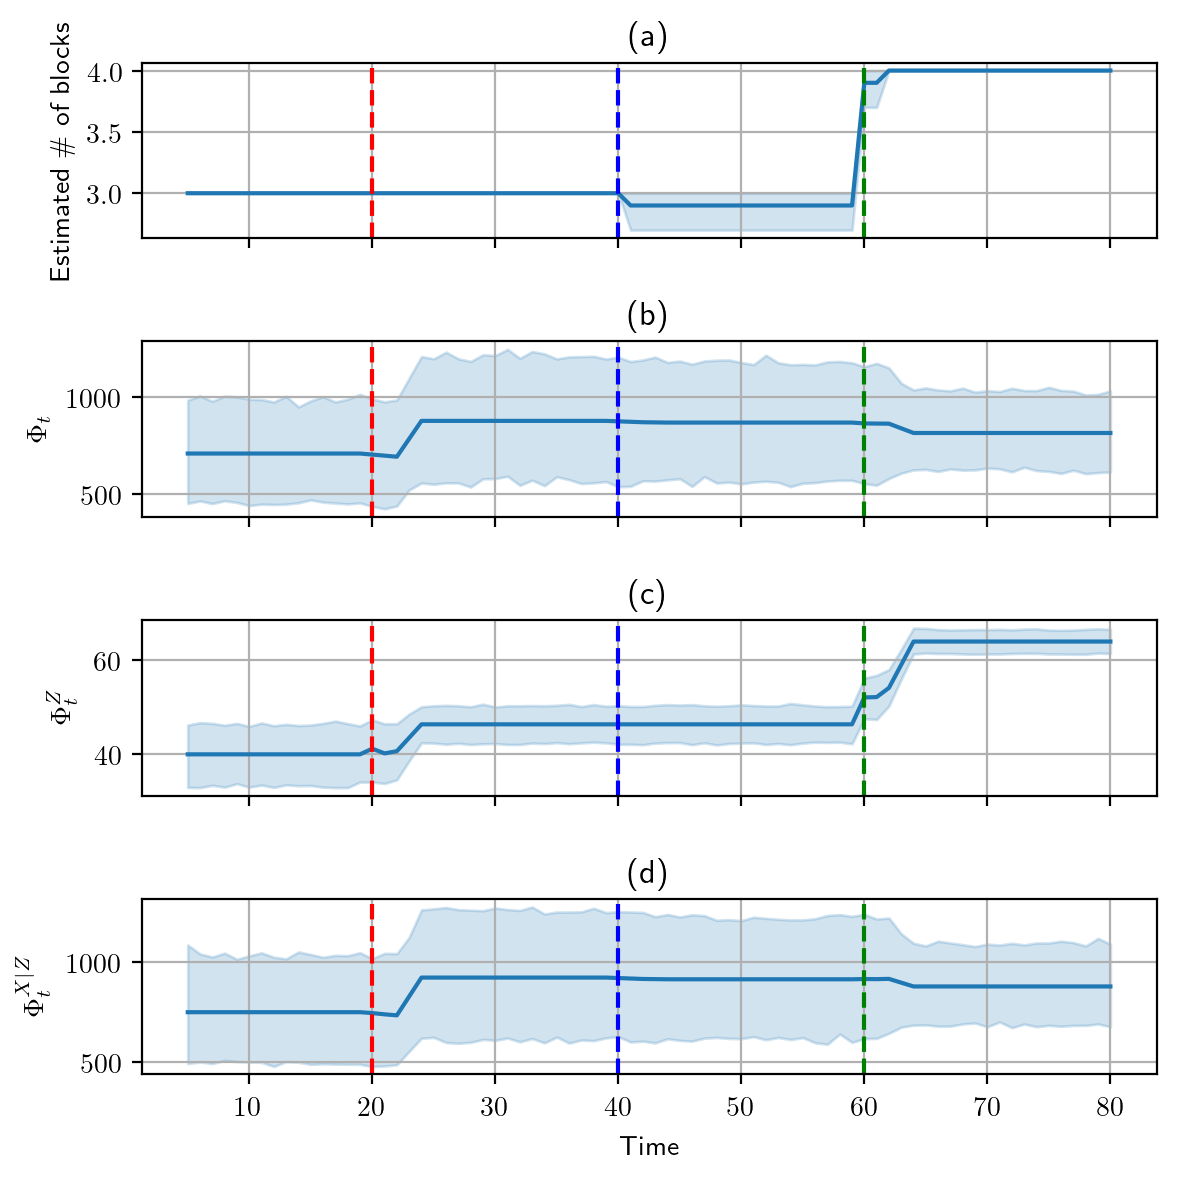

In [50]:
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(6, 6), dpi=200)

sns.lineplot(x='variable', y='value', data=idxes_all_df_melt, ax=axes[0])
axes[0].axvline(x=20, color='red', linestyle='dashed')
axes[0].axvline(x=40, color='blue', linestyle='dashed')
axes[0].axvline(x=60, color='green', linestyle='dashed')
axes[0].grid()
axes[0].set_title('(a)')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Estimated \# of blocks')

sns.lineplot(x='variable', y='value', data=dnml_df_melt, ax=axes[1])
axes[1].axvline(x=20, color='red', linestyle='dashed')
axes[1].axvline(x=40, color='blue', linestyle='dashed')
axes[1].axvline(x=60, color='green', linestyle='dashed')
axes[1].grid()
axes[1].set_title('(b)')
axes[1].set_xlabel('Time')
axes[1].set_ylabel(r'$\Phi_{t}$')

sns.lineplot(x='variable', y='value', data=nml_z_df_melt, ax=axes[2])
axes[2].axvline(x=20, color='red', linestyle='dashed')
axes[2].axvline(x=40, color='blue', linestyle='dashed')
axes[2].axvline(x=60, color='green', linestyle='dashed')
axes[2].grid()
axes[2].set_title('(c)')
axes[2].set_xlabel('Time')
axes[2].set_ylabel(r'$\Phi_{t}^{Z}$')

sns.lineplot(x='variable', y='value', data=nml_x_z_df_melt, ax=axes[3])
axes[3].axvline(x=20, color='red', linestyle='dashed')
axes[3].axvline(x=40, color='blue', linestyle='dashed')
axes[3].axvline(x=60, color='green', linestyle='dashed')
axes[3].grid()
axes[3].set_title('(d)')
axes[3].set_xlabel('Time')
axes[3].set_ylabel(r'$\Phi_{t}^{X|Z}$')

fig.tight_layout()

plt.show()